In [15]:
from keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam  # Adapt momentum. It uses the benefits of RMSprop and Gradient Descent with momentum. Hyper params: learning rate, beta for momentum
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import plot_model
import os
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from PIL import Image, ImageEnhance
from tqdm import tqdm

1. **Data IMPORTATION :**

In [16]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/'
unique_labels = os.listdir(train_dir)
train_paths = []
train_labels = []
val_paths = []
val_labels = []
test_paths = []
test_labels = []           
directories = {'train_dir':train_dir, 'val_dir':val_dir, 'test_dir':test_dir}
paths_dict = {'train_paths':train_paths, 'val_paths':val_paths, 'test_paths':test_paths}
labels_dict = {'train_labels':train_labels, 'val_labels':val_labels, 'test_labels':test_labels}

for data in ['train', 'val', 'test']: 
    directory = directories[data+'_dir']
    for label in unique_labels:
        for image in os.listdir(directory + label):
            paths_dict[data+'_paths'].append(directory + label + '/' + image)
            labels_dict[data+'_labels'].append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)
val_paths, val_labels = shuffle(val_paths, val_labels)
test_paths, test_labels = shuffle(test_paths, test_labels)

print("training set :",len(train_paths))
print("validation set :",len(val_paths))
print("testing set :", len(test_paths))



training set : 5216
validation set : 16
testing set : 624


2.1. ***Data Visualization***

Text(0.5, 1.0, 'Distribution of categories in the dataset')

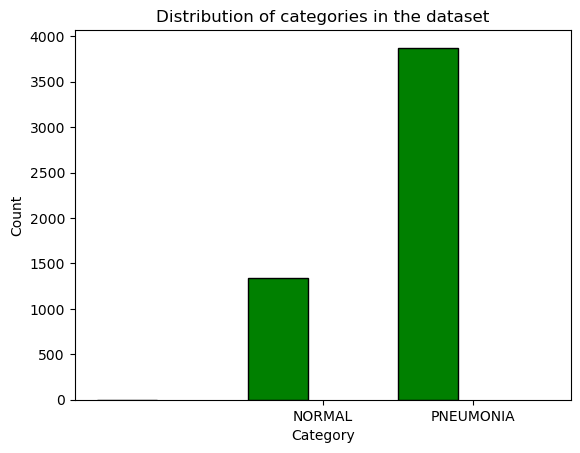

In [17]:
category_dict = {
    "NORMAL": 0,
    "PNEUMONIA": 1
}

l = [category_dict.get(item.upper(), -1) for item in train_labels]

fig, ax = plt.subplots()
ax.hist(l, bins=[-1, 0, 1, 2], align='left', edgecolor='black', color='green', width=0.4)
ax.set_xticks([0, 1])
ax.set_xticklabels(['NORMAL', 'PNEUMONIA'])
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_title('Distribution of categories in the dataset')



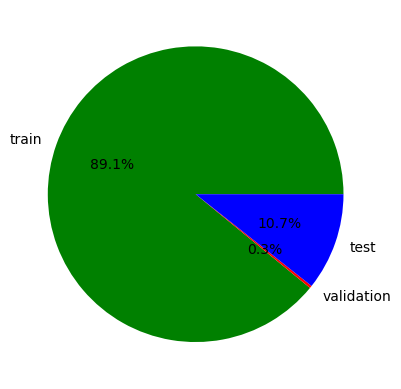

In [18]:
plt.pie([len(train_paths), len(val_paths), len(test_paths)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['green', 'red', 'blue'])
plt.show()

The data seems imbalanced . To increase the no. of training examples, we will use data augmentation


2.2. **Making the ratio 60/20/20**

In [19]:
data_paths = []
data_paths.extend(train_paths)
data_paths.extend(val_paths)
data_paths.extend(test_paths)
data_labels = []
data_labels.extend(train_labels)
data_labels.extend(val_labels)
data_labels.extend(test_labels)
train_paths, test_paths, train_labels, test_labels = train_test_split(data_paths,data_labels, test_size=0.2, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(data_paths,data_labels, test_size=0.25, random_state=42)

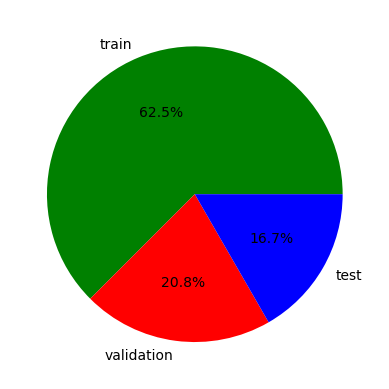

In [20]:
plt.pie([len(train_paths), len(val_paths), len(test_paths)],
        labels=['train', 'validation', 'test'], autopct='%.1f%%', colors=['green', 'red', 'blue'])
plt.show()

***NOW WE HAVE A MORE BALENCED DATA***

2.3. **Previewing the images of both the classes**

Text(0.5, 1.0, 'PNEUMONIA')

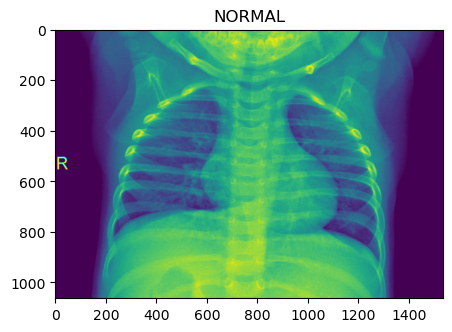

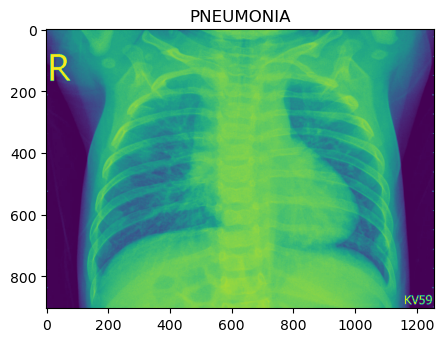

In [21]:
# Load the first image using PIL
image = Image.open(train_paths[0]).convert('L')

# Plot the image using plt
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.title(train_labels[0])

# Load the last image using PIL
image = Image.open(train_paths[-1]).convert('L')

# Plot the image using plt
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.title(train_labels[-1])


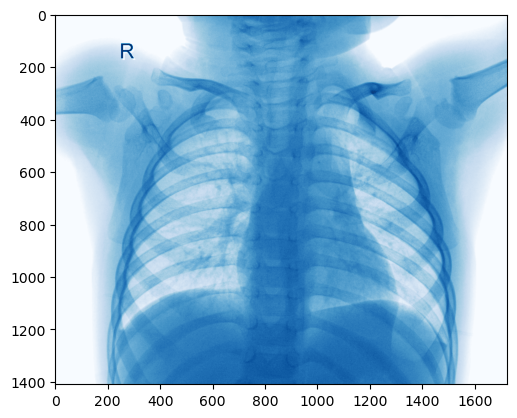

In [22]:
plt.imshow(Image.open(train_paths[2]).convert('L'), cmap='Blues')

3.**PREPROCESSING**

**We can perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

1. *train_paths = np.array(train_paths) / 255*

**The unseen image could have different brightness and contrasts than what it is being trained on. But rotating or flipping doesn't help here.**

In [23]:
IMAGE_SIZE=150
# Create a Sequential model for resizing and rescaling
resize_and_rescale = Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE , IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)    
])

**DATA AUGMENTATION**

In [24]:
# Create a Sequential model for data augmentation
data_augmentation = Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"), # randomly flip inputs horizontally and vertically
    layers.experimental.preprocessing.RandomRotation(0.2), # randomly rotate inputs by a factor of 0.2 degrees

])

**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

For the data augmentation, i choosed to :

Randomly rotate some training images by 30 degrees
Randomly Zoom by 20% some training images
Randomly shift images horizontally by 10% of the width
Randomly shift images vertically by 10% of the height
Randomly flip images horizontally. Once our model is ready, we fit the training dataset.

In [25]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        #shear_range=0.1,
        #fill_mode='nearest'
        brightness_range=[0.8, 1.2],
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
)

**4.1Creating the Model (with Transfert learning ::using VGG16)**

In [26]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze the base model weights
for layer in base_model.layers:
    layer.trainable = False
# Setting the last 3 layers of a pre-trained VGG16 model to be trainable while freezing the rest of the layers
for i in range(3):
    base_model.layers[-2-i].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])
model.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 15,763,650
Trainable params: 8,128,386
N

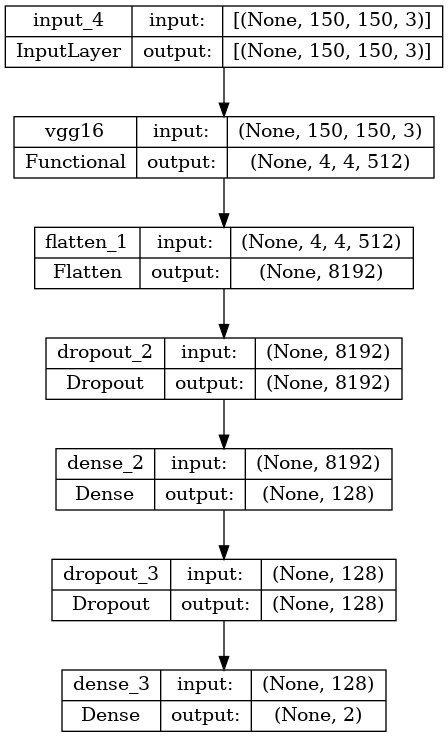

In [27]:
plot_model(model, show_shapes=True)

In [28]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

**4.3 preparing the data (images-->matrices)**

In [29]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(np.random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(np.random.uniform(0.8, 1.2))
    image = np.array(image)/255.0  # normalize
    return image
def load_augmented_image(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

def encode_labels(labels, unique_labels):
    encoded = []
    for label in labels:
        encoded.append(unique_labels.index(label))
    return np.array(encoded)

def decode_labels(encoded, unique_labels):
    labels = []
    for idx in encoded:
        labels.append(unique_labels[idx])
    return np.array(labels)

def datagen(paths, labels, batch_size=12, epochs=1, unique_labels=None):
    """
    Divide each epoch to some steps and in each step of each epoch return the mini batch data.
    """
    for _ in range(epochs):
        for sample_idx in range(0, len(paths), batch_size):
            batch_images = load_augmented_image(paths[sample_idx: sample_idx + batch_size])
            batch_labels = encode_labels(labels[sample_idx: sample_idx + batch_size], unique_labels)
            yield batch_images, batch_labels

**5.Training the models**

MODEL

In [30]:
batch_size = 15
steps = len(train_labels)//batch_size
epochs=10

def train_model(model,batch_size, steps, epochs, unique_labels):
    history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs, unique_labels=unique_labels),
                       epochs=epochs, steps_per_epoch=steps, callbacks = [learning_rate_reduction])
    return history

history = train_model(model,batch_size, steps, epochs, unique_labels)

Epoch 1/10
292/292 [==============================] - 91s 285ms/step - loss: 0.1848 - sparse_categorical_accuracy: 0.9285 - lr: 1.0000e-04
Epoch 2/10
292/292 [==============================] - 59s 201ms/step - loss: 0.1063 - sparse_categorical_accuracy: 0.9596 - lr: 1.0000e-04
Epoch 3/10
292/292 [==============================] - 59s 202ms/step - loss: 0.0742 - sparse_categorical_accuracy: 0.9746 - lr: 1.0000e-04
Epoch 4/10
292/292 [==============================] - 59s 202ms/step - loss: 0.0519 - sparse_categorical_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 5/10
292/292 [==============================] - 58s 200ms/step - loss: 0.0471 - sparse_categorical_accuracy: 0.9824 - lr: 1.0000e-04
Epoch 6/10
292/292 [==============================] - 58s 200ms/step - loss: 0.0322 - sparse_categorical_accuracy: 0.9886 - lr: 1.0000e-04
Epoch 7/10
292/292 [==============================] - 59s 201ms/step - loss: 0.0365 - sparse_categorical_accuracy: 0.9867 - lr: 1.0000e-04
Epoch 8/10
292/292 [=======

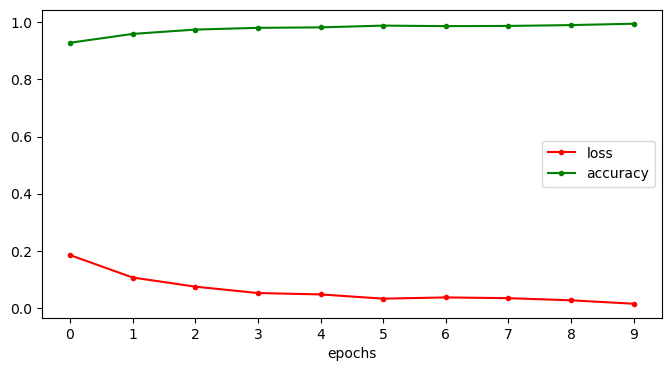

In [34]:
def plot_trining_loss(history, epochs):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], '.r-', label='loss')
    plt.plot(history.history['sparse_categorical_accuracy'], '.g-', label='accuracy')
    plt.xticks(ticks=range(epochs))
    plt.xlabel('epochs')
    plt.legend()
    plt.show()

plot_trining_loss(history, epochs)

**6.Predict for validation**

In [35]:
batch_size =30
steps = len(val_labels)//batch_size
epochs=1

def predict_labels(model, paths, labels, batch_size, steps, epochs, unique_labels):
    y_pred = []
    y_true = []
    # for each mini batch get x,y and predict labels and then append to y_pred
    for x,y in tqdm(datagen(paths, labels, batch_size=batch_size, epochs=epochs, unique_labels=unique_labels), total=steps):
        pred = model.predict(x)  
        pred = np.argmax(pred, axis=-1)
        y_pred.extend(decode_labels(pred, unique_labels))
        y_true.extend(decode_labels(y, unique_labels))
    return y_true, y_pred

y_true, y_pred = predict_labels(model, val_paths, val_labels, batch_size, steps, epochs, unique_labels)

  0%|          | 0/48 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 1/48 [00:03<02:33,  3.27s/it]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 2/48 [00:04<01:25,  1.86s/it]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 3/48 [00:04<00:57,  1.27s/it]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 4/48 [00:05<00:45,  1.03s/it]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 5/48 [00:06<00:39,  1.09it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▎        | 6/48 [00:06<00:35,  1.18it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 7/48 [00:07<00:31,  1.29it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 8/48 [00:08<00:29,  1.35it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 9/48 [00:08<00:28,  1.38it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 10/48 [00:09<00:26,  1.42it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 11/48 [00:09<00:24,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 12/48 [00:10<00:24,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 13/48 [00:11<00:24,  1.45it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 14/48 [00:12<00:23,  1.44it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 15/48 [00:12<00:22,  1.45it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 16/48 [00:13<00:21,  1.46it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 17/48 [00:14<00:21,  1.43it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 18/48 [00:14<00:21,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 19/48 [00:15<00:19,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 20/48 [00:16<00:17,  1.59it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 21/48 [00:16<00:16,  1.61it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 22/48 [00:17<00:16,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 23/48 [00:17<00:15,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 24/48 [00:18<00:15,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 25/48 [00:19<00:15,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 26/48 [00:19<00:14,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 27/48 [00:20<00:13,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 28/48 [00:21<00:12,  1.64it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 29/48 [00:21<00:12,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▎   | 30/48 [00:22<00:11,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 31/48 [00:23<00:11,  1.47it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 32/48 [00:23<00:10,  1.54it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 33/48 [00:24<00:10,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 34/48 [00:25<00:10,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 35/48 [00:26<00:09,  1.36it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 36/48 [00:26<00:08,  1.38it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 37/48 [00:27<00:07,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 38/48 [00:28<00:06,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 39/48 [00:28<00:06,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 40/48 [00:29<00:05,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 41/48 [00:30<00:04,  1.44it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 42/48 [00:30<00:04,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 43/48 [00:31<00:03,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 44/48 [00:32<00:02,  1.58it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 45/48 [00:32<00:01,  1.61it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 46/48 [00:33<00:01,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 47/48 [00:33<00:00,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 48/48 [00:34<00:00,  1.59it/s]

1/1 [==============================] - 1s 1s/step


49it [00:36,  1.35it/s]                        


In [ ]:
print(classification_report(y_true, y_pred))

**7.Evaluate the model by test data**

In [ ]:
batch_size =30
steps = len(test_labels)//batch_size
epochs=1

y_true, y_pred = predict_labels(model,test_paths, test_labels, batch_size, steps, epochs, unique_labels)

In [ ]:
print(classification_report(y_true, y_pred))

In [38]:
model.save('/kaggle/working/usingvgg16')

**USING 3CLASSES**

In [41]:
unique_labels2 = ['NORMAL', 'bacterial', 'viral'] 
def label_types(paths, labels):
    for i, path in enumerate(paths):
        if 'bacteria' in path:
            labels[i] = 'bacterial'
        elif 'virus' in path:
            labels[i] = 'viral'
    return labels

train_labels = label_types(train_paths, train_labels)
val_labels = label_types(val_paths, val_labels)
test_labels = label_types(test_paths, test_labels)

model2 = Sequential()
model2.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model2.add(base_model)
model2.add(Flatten())
model2.add(Dropout(0.3))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(len(unique_labels2), activation='softmax'))
model2.compile(optimizer=Adam(learning_rate=1e-4),
              loss = 'sparse_categorical_crossentropy',
             metrics = ['sparse_categorical_accuracy'])

Epoch 1/10
292/292 [==============================] - 58s 199ms/step - loss: 0.3685 - sparse_categorical_accuracy: 0.8365
Epoch 2/10
292/292 [==============================] - 59s 201ms/step - loss: 0.3332 - sparse_categorical_accuracy: 0.8494
Epoch 3/10
292/292 [==============================] - 59s 201ms/step - loss: 0.3063 - sparse_categorical_accuracy: 0.8666
Epoch 4/10
292/292 [==============================] - 59s 201ms/step - loss: 0.2577 - sparse_categorical_accuracy: 0.8876
Epoch 5/10
292/292 [==============================] - 58s 200ms/step - loss: 0.2010 - sparse_categorical_accuracy: 0.9182
Epoch 6/10
292/292 [==============================] - 59s 201ms/step - loss: 0.1602 - sparse_categorical_accuracy: 0.9406
Epoch 7/10
292/292 [==============================] - 58s 199ms/step - loss: 0.1384 - sparse_categorical_accuracy: 0.9456
Epoch 8/10
292/292 [==============================] - 58s 198ms/step - loss: 0.1133 - sparse_categorical_accuracy: 0.9538
Epoch 9/10
292/292 [====

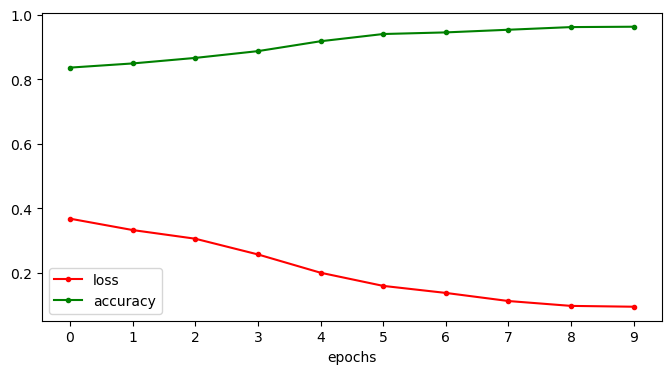

In [43]:
batch_size=15
steps = len(train_paths)//batch_size
epochs=10
history = model2.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs, unique_labels=unique_labels2),
                   epochs=epochs, steps_per_epoch=steps)
# history = train_model(batch_size=batch_size, steps=steps, epochs=epochs, unique_labels=unique_labels2)
plot_trining_loss(history, epochs)

In [44]:
batch_size =30
steps = len(val_labels)//batch_size
epochs=1
y_true, y_pred = predict_labels(model2,val_paths, val_labels, batch_size, steps, epochs, unique_labels2)

  0%|          | 0/48 [00:00<?, ?it/s]

1/1 [==============================] - 0s 148ms/step


  2%|▏         | 1/48 [00:00<00:27,  1.72it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 2/48 [00:01<00:26,  1.75it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 3/48 [00:01<00:21,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 4/48 [00:01<00:20,  2.10it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 5/48 [00:02<00:20,  2.10it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▎        | 6/48 [00:02<00:19,  2.12it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 7/48 [00:03<00:19,  2.14it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 8/48 [00:03<00:19,  2.10it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 9/48 [00:04<00:18,  2.12it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 10/48 [00:04<00:18,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 11/48 [00:05<00:16,  2.25it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 12/48 [00:05<00:16,  2.20it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 13/48 [00:06<00:16,  2.18it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 14/48 [00:06<00:16,  2.11it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 15/48 [00:07<00:15,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 16/48 [00:07<00:15,  2.06it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 17/48 [00:08<00:15,  2.03it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 18/48 [00:08<00:15,  1.99it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 19/48 [00:09<00:14,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 20/48 [00:09<00:12,  2.16it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 21/48 [00:09<00:12,  2.20it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 22/48 [00:10<00:12,  2.15it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 23/48 [00:10<00:12,  2.08it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 24/48 [00:11<00:12,  1.99it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 25/48 [00:12<00:11,  1.94it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 26/48 [00:12<00:11,  1.98it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 27/48 [00:13<00:10,  2.01it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 28/48 [00:13<00:09,  2.18it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 29/48 [00:13<00:08,  2.13it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▎   | 30/48 [00:14<00:08,  2.09it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 31/48 [00:14<00:08,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 32/48 [00:15<00:07,  2.16it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 33/48 [00:15<00:06,  2.22it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 34/48 [00:16<00:06,  2.11it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 35/48 [00:16<00:06,  2.05it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 36/48 [00:17<00:05,  2.02it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 37/48 [00:17<00:05,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 38/48 [00:18<00:04,  2.04it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████▏ | 39/48 [00:18<00:04,  2.08it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 40/48 [00:19<00:03,  2.05it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 41/48 [00:19<00:03,  1.97it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 42/48 [00:20<00:02,  2.07it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 43/48 [00:20<00:02,  2.09it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 44/48 [00:21<00:01,  2.20it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 45/48 [00:21<00:01,  2.24it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 46/48 [00:22<00:01,  1.73it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 47/48 [00:22<00:00,  1.82it/s]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 48/48 [00:23<00:00,  1.89it/s]

1/1 [==============================] - 0s 25ms/step


49it [00:23,  2.07it/s]                        


In [45]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

      NORMAL       0.90      0.97      0.93       398
   bacterial       0.85      0.87      0.86       698
       viral       0.72      0.62      0.67       368

    accuracy                           0.83      1464
   macro avg       0.82      0.82      0.82      1464
weighted avg       0.83      0.83      0.83      1464



In [46]:
model2.save('/kaggle/working/sequencialfor3classes')